# Brain Tumor MRI Classification — Augmentation-Based Training Pipeline

**Objective:**  
Train and evaluate a multi-class CNN for brain tumor classification using **data augmentation applied only to the training set**, and analyze its impact on generalization, robustness, and interpretability using Grad-CAM.

**Pipeline scope:**
- Input: Cropped MRI images produced by the preprocessing pipeline
- Model: ResNet-50 with full fine-tuning
- Training strategy: Augmentation on training data only, clean validation and test sets
- Evaluation: Accuracy, class-wise metrics, confusion matrix, inference time
- Interpretability: Grad-CAM and Guided Grad-CAM on the best validation model


In [39]:
%pip -q install imutils tqdm

import os
from pathlib import Path

import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.


## Dataset Paths and Preprocessing Configuration

This block defines all dataset paths and preprocessing parameters used throughout the project.  
Separate root directories are specified for training and testing data to ensure a clean and reproducible data split.

The cropped output directories are defined explicitly, reflecting the decision to **store preprocessed images separately** rather than modifying the original dataset.  
This allows the preprocessing step to be fully traceable and repeatable without data leakage.

Several key preprocessing parameters are configured here:
- `IMG_SIZE` defines the target spatial resolution for downstream processing and model input consistency.
- `THRESH_VAL` controls the threshold used to identify and remove empty or black regions in MRI images.
- `ADD_PIXELS` allows optional padding around detected regions, enabling fine control over cropping behavior.

By centralizing these parameters, the preprocessing pipeline can be easily adjusted, audited, and reused across both the augmentation and non-augmentation workflows.  
This explicit configuration reflects a deliberate design choice rather than reliance on hard-coded defaults.


In [40]:
# Change these if folders differ
TRAIN_ROOT = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Trainingbrain")
TEST_ROOT  = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain")

OUT_TRAIN = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training")
OUT_TEST  = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing")

IMG_SIZE = 256
THRESH_VAL = 45
ADD_PIXELS = 0

print("Train root:", TRAIN_ROOT)
print("Test root :", TEST_ROOT)
print("Out train :", OUT_TRAIN)
print("Out test  :", OUT_TEST)


Train root: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Trainingbrain
Test root : /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain
Out train : /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training
Out test  : /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing


## Class Discovery and Dataset Structure Validation

This utility function is used to automatically discover class labels based on the directory structure of the dataset.  
Rather than hard-coding class names, the function dynamically lists valid subfolders, ensuring flexibility if classes are added or removed.

Hidden directories are explicitly excluded to avoid unintended artifacts from system files.  
By applying the same logic to both training and testing directories, this step also serves as a **sanity check** to confirm consistent class structures across splits.

This approach improves robustness and reproducibility, and avoids manual label mismatches that could otherwise lead to silent training or evaluation errors.

In [41]:
def list_classes(root_dir: Path):
    return sorted([p.name for p in root_dir.iterdir() if p.is_dir() and not p.name.startswith(".")])

train_classes = list_classes(TRAIN_ROOT)
test_classes  = list_classes(TEST_ROOT)

print("Training classes:", train_classes)
print("Testing classes :", test_classes)


Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing classes : ['glioma', 'meningioma', 'notumor', 'pituitary']


## Core Cropping Logic: Removal of Non-Informative Regions

This function implements the central preprocessing contribution of this project:  
the **automatic removal of empty and non-informative regions** from brain MRI images.

The cropping strategy is based on detecting the **largest connected contour** in the image, which typically corresponds to the brain region, while excluding surrounding black background areas that do not contribute meaningful information to learning.

The process consists of:
- Converting the image to grayscale and applying Gaussian blur to reduce noise.
- Thresholding and morphological operations to isolate foreground regions.
- Identifying the largest contour by area as a proxy for the relevant anatomical structure.
- Cropping the image using extreme contour points (left, right, top, bottom) to form a tight region of interest.

A configurable padding parameter (`add_pixels`) allows controlled expansion of the cropped region if needed, while fallback logic ensures robustness in cases where no contour is detected.

This cropping step is intentionally performed **before resizing and augmentation**, ensuring that the model is trained on spatially meaningful content rather than background artifacts.  
By explicitly removing blank regions, the network is encouraged to learn features from relevant anatomical structures, improving both training stability and interpretability.

In [ ]:
def crop_img(bgr_img: np.ndarray, thresh_val: int = 45, add_pixels: int = 0) -> np.ndarray:
    
    if bgr_img is None:
        return None

    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    mask = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)[1]
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if not cnts:
        return bgr_img  # fallback

    c = max(cnts, key=cv2.contourArea)

    ext_left  = tuple(c[c[:, :, 0].argmin()][0])
    ext_right = tuple(c[c[:, :, 0].argmax()][0])
    ext_top   = tuple(c[c[:, :, 1].argmin()][0])
    ext_bot   = tuple(c[c[:, :, 1].argmax()][0])

    x0 = max(ext_left[0]  - add_pixels, 0)
    x1 = min(ext_right[0] + add_pixels, bgr_img.shape[1])
    y0 = max(ext_top[1]   - add_pixels, 0)
    y1 = min(ext_bot[1]   + add_pixels, bgr_img.shape[0])

    cropped = bgr_img[y0:y1, x0:x1].copy()
    return cropped if cropped.size else bgr_img

## Preprocessing Verification: Single-Image Cropping Demonstration

Before applying the cropping procedure to the full dataset, a single MRI image is processed as a demonstration and sanity check.  
This step verifies that the cropping logic behaves as intended on a representative sample before large-scale preprocessing is performed.

The image is explicitly loaded and resized to a fixed resolution to standardize the input format.  
The cropping function is then applied using the configured threshold and padding parameters, and the resulting shape is compared to the original image.

By printing the original and cropped dimensions, this block provides a transparent and reproducible check that the preprocessing step removes non-informative regions while preserving the relevant anatomical content.  
This validation step helps prevent silent preprocessing errors from propagating into downstream training pipelines.

In [43]:
demo_path = TRAIN_ROOT / "meningioma" / "Tr-me_0016.jpg"
img = cv2.imread(str(demo_path))

if img is None:
    raise FileNotFoundError(f"Could not read: {demo_path}")

img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
cropped = crop_img(img, thresh_val=THRESH_VAL, add_pixels=ADD_PIXELS)

print("Original shape:", img.shape)
print("Cropped shape :", cropped.shape)

Original shape: (224, 224, 3)
Cropped shape : (152, 143, 3)


## Visual Validation of Cropping Logic: Contours and Extreme Points

This block provides a visual explanation of how the cropping strategy operates internally.  
Instead of treating the cropping function as a black box, intermediate steps are explicitly visualized to confirm correct behavior.

First, the largest foreground contour extracted from the thresholded mask is overlaid on the original MRI image.  
Next, the extreme points of this contour (left, right, top, bottom) are highlighted to show how the bounding region of interest is determined.  
Finally, the resulting cropped image is displayed, illustrating the effect of removing non-informative background regions.

This step serves as a qualitative sanity check, ensuring that the cropping logic consistently captures the relevant anatomical area before it is applied to the full dataset.  
By visualizing each intermediate stage, this block increases transparency, debuggability, and confidence in the preprocessing pipeline.

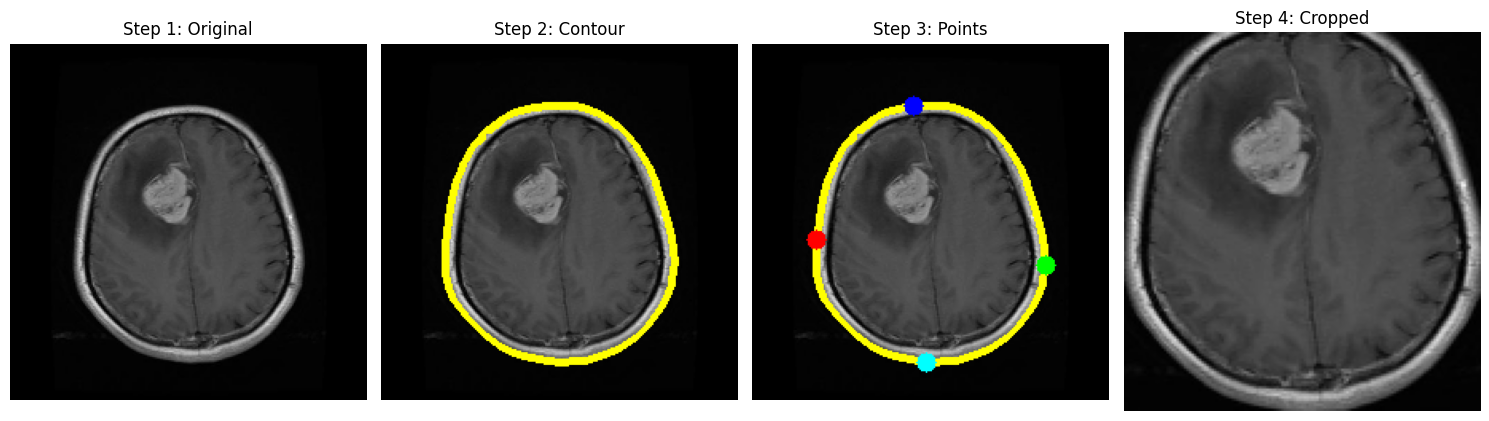

In [44]:
def demo_contour_and_points(bgr_img: np.ndarray, thresh_val=45):
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    mask = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)[1]
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if not cnts:
        return bgr_img, bgr_img, bgr_img

    c = max(cnts, key=cv2.contourArea)

    extLeft  = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop   = tuple(c[c[:, :, 1].argmin()][0])
    extBot   = tuple(c[c[:, :, 1].argmax()][0])

    img_cnt = cv2.drawContours(bgr_img.copy(), [c], -1, (0, 255, 255), 3)

    img_pnt = img_cnt.copy()
    img_pnt = cv2.circle(img_pnt, extLeft,  6, (0, 0, 255),   -1)
    img_pnt = cv2.circle(img_pnt, extRight, 6, (0, 255, 0),   -1)
    img_pnt = cv2.circle(img_pnt, extTop,   6, (255, 0, 0),   -1)
    img_pnt = cv2.circle(img_pnt, extBot,   6, (255, 255, 0), -1)

    return bgr_img, img_cnt, img_pnt

to_rgb = lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

img0, img_cnt, img_pnt = demo_contour_and_points(img, thresh_val=THRESH_VAL)
new_img = crop_img(img, thresh_val=THRESH_VAL, add_pixels=ADD_PIXELS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1); plt.imshow(to_rgb(img0));    plt.title("Step 1: Original"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(to_rgb(img_cnt)); plt.title("Step 2: Contour");  plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(to_rgb(img_pnt)); plt.title("Step 3: Points");   plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(to_rgb(new_img)); plt.title("Step 4: Cropped");  plt.axis("off")
plt.tight_layout()
plt.show()

## Dataset-Wide Preprocessing: Split-Aware Cropping and Saving

This helper function applies the cropping procedure to an entire dataset split, either training or testing, while preserving the original class structure.  
By processing each split independently, this design explicitly prevents data leakage between training and test sets.

For each class folder, images are loaded, cropped using the previously defined largest-contour strategy, resized to a fixed resolution, and saved to a dedicated output directory.  
Only valid image files are processed, and unreadable files are safely skipped to ensure robustness during large-scale preprocessing.

The use of a single, parameterized function allows the same preprocessing logic to be consistently applied across different dataset splits while keeping configuration flexible.  
Progress bars are included to provide transparency during long-running operations and to make preprocessing traceable and reproducible.

In [45]:
def process_split(src_root: Path, dst_root: Path, img_size: int, thresh_val: int, add_pixels: int):
    dst_root.mkdir(parents=True, exist_ok=True)

    class_names = list_classes(src_root)
    print(f"\nProcessing: {src_root}  ->  {dst_root}")
    print("Classes:", class_names)

    for cls in class_names:
        src_dir = src_root / cls
        out_dir = dst_root / cls
        out_dir.mkdir(parents=True, exist_ok=True)

        files = [p for p in src_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
        for p in tqdm(files, desc=f"Cropping {cls}", leave=False):
            img_bgr = cv2.imread(str(p))
            if img_bgr is None:
                continue

            cropped = crop_img(img_bgr, thresh_val=thresh_val, add_pixels=add_pixels)
            cropped = cv2.resize(cropped, (img_size, img_size))
            cv2.imwrite(str(out_dir / p.name), cropped)

## Applying the Cropping Pipeline to the Training Dataset

This block executes the preprocessing pipeline for the **training split** using the previously defined helper function.  
All training images are cropped, resized, and saved to a dedicated output directory while preserving the original class structure.

The preprocessing parameters (image size, threshold value, and optional padding) are passed explicitly, ensuring that the transformation applied to the training data is fully transparent and reproducible.  
By running this step independently for the training split, the pipeline guarantees that preprocessing decisions are applied consistently while maintaining a strict separation from validation and test data.

This explicit execution step marks the transition from preprocessing design to dataset transformation and forms the foundation for the downstream training pipelines.

In [46]:
process_split(
    src_root=TRAIN_ROOT,
    dst_root=OUT_TRAIN,
    img_size=IMG_SIZE,
    thresh_val=THRESH_VAL,
    add_pixels=ADD_PIXELS
)


Processing: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Trainingbrain  ->  /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Applying the Cropping Pipeline to the Test Dataset

This block applies the same deterministic cropping and resizing procedure to the **test split** of the dataset.  
Using identical preprocessing parameters for both training and test data ensures that performance differences are attributable to the learning process rather than preprocessing inconsistencies.

The test data is processed independently and stored in a separate output directory, preserving a strict separation between training and evaluation data.  
This design prevents data leakage and guarantees that all reported performance metrics reflect true generalization to unseen data.

The resulting cropped test dataset serves as the final input for unbiased model evaluation and for qualitative analysis using Grad-CAM.

In [47]:
process_split(
    src_root=TEST_ROOT,
    dst_root=OUT_TEST,
    img_size=IMG_SIZE,
    thresh_val=THRESH_VAL,
    add_pixels=ADD_PIXELS
)



Processing: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain  ->  /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Dataset Integrity Check: Image Counts per Class

This block performs a sanity check to verify the integrity of the cropped datasets after preprocessing.  
For each class, the number of images in the cropped training and test directories is counted and compared against expectations.

This step ensures that:
- No images were accidentally dropped during cropping.
- Class distributions remain unchanged by preprocessing.
- The folder structure is preserved correctly for downstream loading.

By explicitly validating image counts after preprocessing, this check helps detect silent errors early and ensures that subsequent training and evaluation steps are based on a complete and consistent dataset.

In [48]:
def count_images_per_class(root_dir: Path):
    counts = {}
    for cls in list_classes(root_dir):
        cls_dir = root_dir / cls
        counts[cls] = len([p for p in cls_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])
    return counts

train_out_counts = count_images_per_class(OUT_TRAIN)
test_out_counts  = count_images_per_class(OUT_TEST)

print("Cropped TRAIN counts:", train_out_counts)
print("Cropped TEST counts :", test_out_counts)

Cropped TRAIN counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Cropped TEST counts : {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


## Qualitative Validation: Visual Inspection of Cropped Samples

This block performs a final qualitative check of the preprocessing pipeline by visually inspecting a subset of cropped images from a selected class.  
A small number of samples are displayed to verify that the cropping logic consistently removes non-informative background regions while preserving the relevant anatomical structures.

By examining multiple images side by side, this step helps confirm that:
- The region of interest is correctly centered across samples.
- No clinically relevant information is unintentionally removed.
- Cropped images remain visually consistent within a class.

This visual validation complements the quantitative integrity checks and provides additional confidence that the preprocessing pipeline produces meaningful inputs for downstream model training and interpretability analysis.

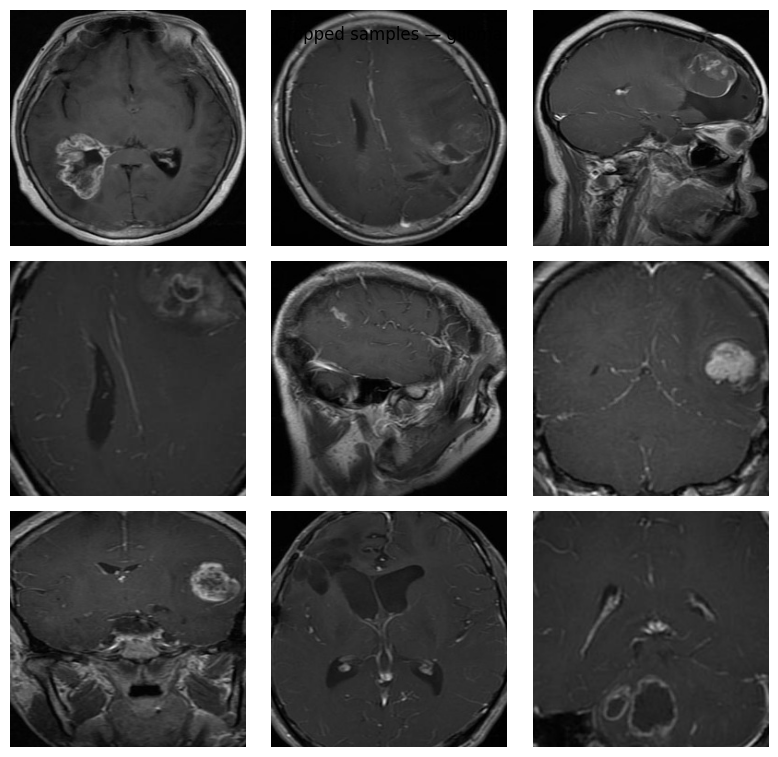

In [49]:
sample_class = train_classes[0] if train_classes else "meningioma"
sample_dir = OUT_TRAIN / sample_class
sample_files = [p for p in sample_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]][:9]

plt.figure(figsize=(8, 8))
for i, p in enumerate(sample_files):
    img_bgr = cv2.imread(str(p))
    if img_bgr is None:
        continue
    plt.subplot(3, 3, i + 1)
    plt.imshow(to_rgb(img_bgr))
    plt.axis("off")
plt.suptitle(f"Cropped samples — {sample_class}", y=0.92)
plt.tight_layout()
plt.show()

## Pipeline Completion and Transition to Model Training

This block marks the completion of the preprocessing and cropping pipeline.  
At this stage, all MRI images have been cleaned, cropped, validated, and stored in dedicated output directories for training and testing.

The printed reminder explicitly documents the **next steps**, which are intentionally carried out in a separate notebook (`brain_mri_preprocessing_pipeline_aug`).  
This separation enforces a clear modular pipeline structure, where preprocessing and model training are decoupled for better reproducibility, debugging, and comparison.

The upcoming steps include loading the cropped datasets, creating train–validation splits, applying data augmentation **only to the training data**, and performing model training, evaluation, and Grad-CAM analysis.  
By explicitly outlining this transition, the overall workflow remains transparent, traceable, and easy to audit.

In [50]:
print(
    "Cropping pipeline complete.\n"
    "Next in brain_mri_preprocessing_pipeline_aug:\n"
    "1) Load OUT_TRAIN / OUT_TEST into arrays\n"
    "2) Split train/val\n"
    "3) Apply ImageDataGenerator augmentation on TRAIN only\n"
    "4) Build + compile model\n"
    "5) Train + evaluate + save + reports\n"
)

Cropping pipeline complete.
Next in brain_mri_preprocessing_pipeline_aug:
1) Load OUT_TRAIN / OUT_TEST into arrays
2) Split train/val
3) Apply ImageDataGenerator augmentation on TRAIN only
4) Build + compile model
5) Train + evaluate + save + reports



## Training Pipeline (Augmentation Version): Environment and Imports

This notebook implements the **augmentation-based training pipeline** built on top of the cropped dataset produced in the preprocessing notebook.  
The workflow here starts after cropping is complete and focuses on model training, evaluation, and interpretability.

The imports are grouped by purpose:
- **Data handling and visualization** (`numpy`, `cv2`, `matplotlib`, `tqdm`) for loading images, inspecting samples, and tracking progress.
- **Reproducible dataset preparation** (`shuffle`, `train_test_split`) to create consistent train/validation splits and avoid ordering bias.
- **Model training framework** (`tensorflow`) used to build and train the deep learning model.
- **Augmentation** (`ImageDataGenerator`) applied *only to the training split* to improve generalization while keeping validation/test untouched.
- **Architecture** (`ResNet50` + custom head layers) to leverage transfer learning with a controlled, lightweight classification head.
- **Callbacks** (`EarlyStopping`, `ModelCheckpoint`, `ReduceLROnPlateau`) to stabilize training, prevent overfitting, and ensure the best-performing model is saved for later Grad-CAM analysis.

This explicit separation into a dedicated augmentation notebook supports a controlled comparison against the non-augmentation pipeline, while keeping preprocessing and training modular and reproducible.

In [51]:
import os
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


## Dataset Configuration and Training Hyperparameters

This block defines the dataset paths and core training parameters for the augmentation-based pipeline.  
The input data is loaded exclusively from the **cropped training and test directories** generated in the preprocessing notebook, ensuring a clear separation between preprocessing and model training.

Class labels are explicitly defined to establish a fixed multi-class classification setup and to ensure consistent label ordering across training, validation, testing, and evaluation stages.  
The image size is set to a uniform resolution to match the ResNet-50 input requirements and to maintain consistency across both augmentation and non-augmentation pipelines.

Training hyperparameters such as batch size and number of epochs are specified here to centralize configuration and support reproducibility.  
By keeping these settings identical across pipelines, any observed performance differences can be attributed to the presence or absence of data augmentation rather than changes in model or training configuration.

In [52]:
OUT_TRAIN = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training")
OUT_TEST  = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing")

CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]
NUM_CLASSES = len(CLASSES)

IMAGE_SIZE = 200
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)

BATCH_SIZE = 28
EPOCHS = 65

print("Cropped train:", OUT_TRAIN)
print("Cropped test :", OUT_TEST)

Cropped train: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training
Cropped test : /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing


## Dataset Audit: Class Distribution after Cropping

This block performs a systematic audit of the cropped dataset to analyze class distribution across the training and test splits.  
All image paths and corresponding class labels are indexed into a structured table, enabling transparent inspection of the dataset composition after preprocessing.

The resulting class frequency counts show that the dataset contains **7,023 images across four classes**.  
The *no tumor* class has the highest representation with **2,000 images**, followed by *pituitary* (**1,757 images**), *meningioma* (**1,645 images**), and *glioma* (**1,621 images**).

These results confirm that all classes are correctly preserved after cropping and that no class was unintentionally removed or disproportionately affected by the preprocessing step.  
While a moderate class imbalance is present, it is consistent across both the augmentation and non-augmentation pipelines, ensuring a fair and controlled comparison during model training and evaluation.

Bar and pie charts are used to visualize both absolute class counts and relative class proportions, providing an intuitive overview of the dataset structure.

Class frequency counts:
Class: notumor, Count: 2000 images
Class: pituitary, Count: 1757 images
Class: meningioma, Count: 1645 images
Class: glioma, Count: 1621 images

Total dataset size is: 7023 images
Number of classes: 4 classes


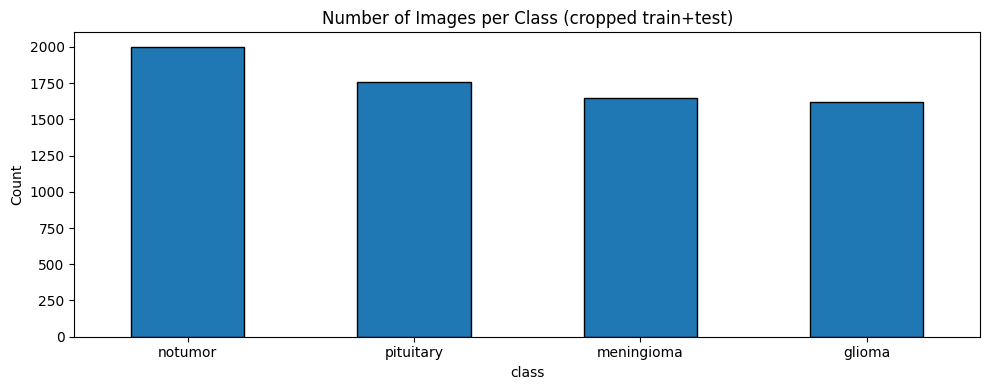

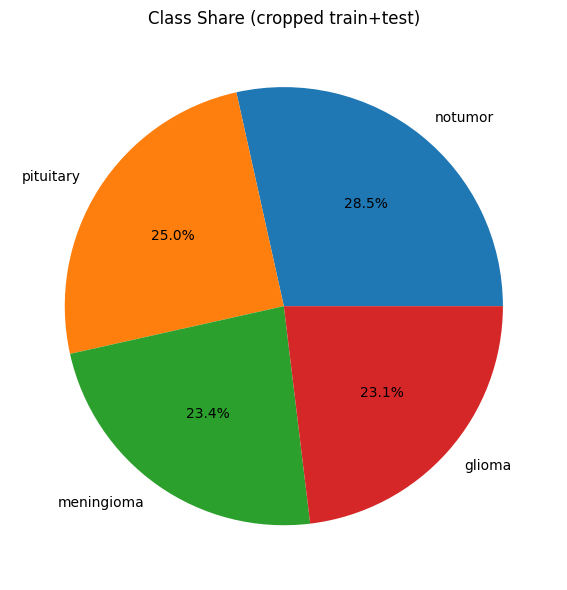

In [53]:
import pandas as pd

def index_images(root_dir: Path, class_names: list[str]) -> pd.DataFrame:
    rows = []
    for cls in class_names:
        cls_dir = root_dir / cls
        if not cls_dir.exists():
            continue
        for p in cls_dir.iterdir():
            if p.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                rows.append({"path": str(p), "class": cls})
    return pd.DataFrame(rows)

df_train = index_images(OUT_TRAIN, CLASSES)
df_test  = index_images(OUT_TEST, CLASSES)
df_all = pd.concat([df_train.assign(split="train"), df_test.assign(split="test")], ignore_index=True)

class_count = df_all["class"].value_counts()
print("Class frequency counts:")
for cls, cnt in class_count.items():
    print(f"Class: {cls}, Count: {cnt} images")

print(f"\nTotal dataset size is: {len(df_all)} images")
print(f"Number of classes: {df_all['class'].nunique()} classes")

plt.figure(figsize=(10, 4))
class_count.plot(kind="bar", edgecolor="black")
plt.title("Number of Images per Class (cropped train+test)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
class_count.plot(kind="pie", autopct="%1.1f%%")
plt.title("Class Share (cropped train+test)")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Dataset Loading and Image Representation Design

This block loads the cropped MRI images from disk and converts them into NumPy arrays suitable for model training and evaluation.  
Rather than directly using raw RGB images, a custom preprocessing sequence is applied to enhance structural information relevant for brain MRI analysis.

Each image is processed as follows:
- Images are loaded in **grayscale**, reflecting the native intensity-based nature of MRI data.
- A **bilateral filter** is applied to reduce noise while preserving important edges and anatomical boundaries.
- The filtered grayscale image is converted into a **pseudo-color representation using the BONE colormap**, producing a three-channel image compatible with pretrained CNN architectures.
- Images are resized to a fixed resolution of **200 × 200 pixels** to ensure consistent input dimensions.

After preprocessing, the resulting dataset consists of **5,712 training images** and **1,311 test images**, each with shape **(200, 200, 3)**.  
The corresponding label arrays contain one integer class label per image, confirming a multi-class, single-label classification setup.

All pixel values are normalized to the range **[0, 1]**, which stabilizes optimization during training.  
The same loading and preprocessing logic is applied consistently to both training and test data, ensuring that downstream performance differences arise from the training strategy rather than input inconsistencies.

This explicit dataset construction step confirms that the cropped dataset is correctly structured and ready for controlled comparison between the augmentation and non-augmentation pipelines.

In [54]:
def load_split_from_folders(root_dir: Path, class_names: list[str], image_size=(200, 200)):
    X, y = [], []
    for cls_idx, cls_name in enumerate(class_names):
        folder = root_dir / cls_name
        if not folder.exists():
            raise FileNotFoundError(f"Missing folder: {folder}")

        files = [p for p in folder.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
        for p in tqdm(files, desc=f"Loading {cls_name}", leave=False):
            gray = cv2.imread(str(p), 0)
            if gray is None:
                continue

            gray = cv2.bilateralFilter(gray, 2, 50, 50) #denoise
            pseudo = cv2.applyColorMap(gray, cv2.COLORMAP_BONE)  # BGR
            pseudo = cv2.resize(pseudo, image_size)

            X.append(pseudo)
            y.append(cls_idx)

    X = np.array(X, dtype=np.float32) / 255.0 #normalizes images to the range 0–1
    y = np.array(y, dtype=np.int32)
    return X, y

X_train_all, y_train_all = load_split_from_folders(OUT_TRAIN, CLASSES, image_size=IMG_SIZE)
X_test, y_test = load_split_from_folders(OUT_TEST, CLASSES, image_size=IMG_SIZE)

print("Train:", X_train_all.shape, y_train_all.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (5712, 200, 200, 3) (5712,)
Test : (1311, 200, 200, 3) (1311,)


## Qualitative Data Check: Preview of Preprocessed Training Images

This block provides a quick visual inspection of a small subset of preprocessed training images before model training begins.  
Nine sample images are displayed along with their corresponding class labels to verify that the loading, preprocessing, and label encoding steps behave as expected.

By visualizing the pseudo-colored MRI images after grayscale conversion, filtering, resizing, and normalization, this step confirms that:
- The image representation is visually consistent and meaningful.
- Class labels align correctly with the displayed images.
- No unexpected artifacts were introduced during preprocessing.

This qualitative check complements earlier quantitative audits and helps ensure that the data entering the model accurately reflects the intended preprocessing design.

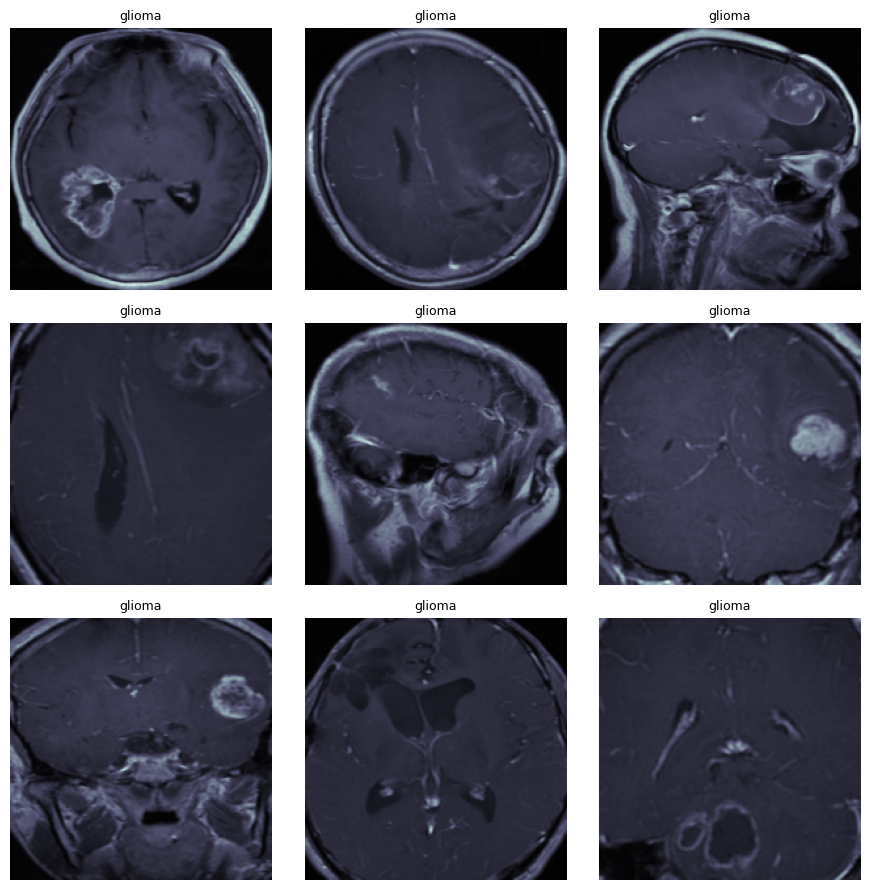

In [55]:
plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    img_bgr = (X_train_all[i] * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(CLASSES[int(y_train_all[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Label Preparation for CNN Training: Shuffling and One-Hot Encoding

This block prepares the dataset labels in a form that is compatible with convolutional neural network (CNN) training.  
Before encoding, the training data is **randomly shuffled** to break any implicit ordering that may exist due to the directory-based loading process.

Shuffling is important for CNN optimization because training is performed in mini-batches.  
If samples from the same class appear consecutively, the network may receive biased gradient updates, which can slow convergence or lead to suboptimal learning.  
Random shuffling ensures that each mini-batch contains a diverse mixture of classes, resulting in more stable and representative gradient updates during backpropagation.

Next, the integer class labels are converted into **one-hot encoded vectors**.  
This transformation is required because the CNN is trained using a **softmax output layer** together with a **categorical cross-entropy loss function**.  
One-hot encoding allows the loss function to compare the predicted class probability distribution with the true class distribution in a mathematically correct way.

After this step, the label tensors have shape `(N, NUM_CLASSES)`, confirming that the task is formulated as a **multi-class, single-label classification problem**.  
This representation enables the network to learn class-specific decision boundaries while producing normalized probability outputs for each class.

In [56]:
X_train_all, y_train_all = shuffle(X_train_all, y_train_all, random_state=37)

y_train_all_oh = tf.keras.utils.to_categorical(y_train_all, num_classes=NUM_CLASSES)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print("y_train_all_oh:", y_train_all_oh.shape)
print("y_test_oh     :", y_test_oh.shape)

y_train_all_oh: (5712, 4)
y_test_oh     : (1311, 4)


## Train–Validation Split and Class Distribution Control

This block splits the preprocessed dataset into **training** and **validation** subsets using a fixed random seed, while keeping the test set fully independent.  
An **80/20 split** is applied to the training data to create a validation set used exclusively for monitoring generalization during CNN training.

From a CNN perspective, this separation has a clear functional role:
- The **training set** is used for weight updates via backpropagation.
- The **validation set** is used to evaluate model performance during training, control callbacks such as early stopping, and tune hyperparameters.
- The **test set** remains untouched until final evaluation to provide an unbiased estimate of real-world performance.

The resulting tensor shapes confirm correct dataset partitioning:
- Training set: **4,569 images**
- Validation set: **1,143 images**
- Test set: **1,311 images**
Each image has shape **(200, 200, 3)**, matching the expected CNN input format.

Class counts are explicitly computed for each split to verify that the original class distribution is preserved:
- Training set: `[1049, 1060, 1282, 1178]`
- Validation set: `[272, 279, 313, 279]`
- Test set: `[300, 306, 405, 300]`

These distributions show that all classes are consistently represented across splits, preventing class-specific bias during training or evaluation.  
By controlling both data partitioning and class balance, this step ensures stable optimization and reliable performance assessment of the CNN.

In [57]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all_oh, test_size=0.2, random_state=27
)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)

print("\nTraining set class counts:", np.sum(y_train, axis=0).astype(int))
print("Validation set class counts:", np.sum(y_val, axis=0).astype(int))
print("Testing set class counts:", np.sum(y_test_oh, axis=0).astype(int))

X_train: (4569, 200, 200, 3)
X_val  : (1143, 200, 200, 3)
X_test : (1311, 200, 200, 3)

Training set class counts: [1049 1060 1282 1178]
Validation set class counts: [272 279 313 279]
Testing set class counts: [300 306 405 300]


## Data Augmentation (Training Only): Domain-Safe Augmentations for Brain MRI

In this pipeline, data augmentation is applied **only to the training set** to improve generalization without contaminating validation or test evaluation.

Because this is **medical imaging**, augmentation choices must preserve anatomical plausibility.  
Overly aggressive transforms can introduce unrealistic samples and may harm CNN learning by creating label noise.

For this reason, augmentation is intentionally **conservative**:
- Small rotations, shifts, and zoom are used to simulate realistic acquisition variability.
- **Horizontal flipping is disabled**, since left–right orientation in brain MRI can be clinically meaningful and flipping may invert hemispheres.

The augmented batches are generated on-the-fly using `ImageDataGenerator` and fed into training via `train_flow`.
Validation and test images remain unaugmented to ensure fair and unbiased performance measurement.

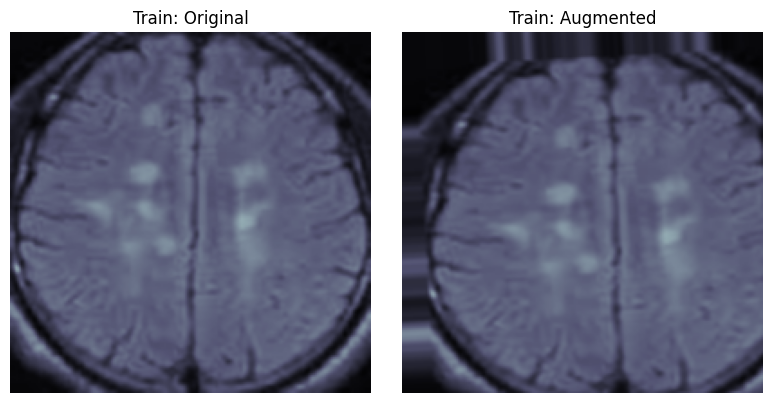

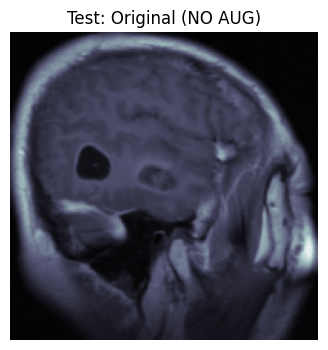

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest" 
)

augmenter.fit(X_train)

train_flow = augmenter.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

# Visual sanity check: original vs augmented 
idx = 0
orig = X_train[idx]
aug = next(augmenter.flow(orig[np.newaxis, ...], batch_size=1, shuffle=False))[0]

def show_bgr01(img01, title):
    img_bgr = (img01 * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); show_bgr01(orig, "Train: Original")
plt.subplot(1, 2, 2); show_bgr01(aug,  "Train: Augmented")
plt.tight_layout()
plt.show()

# Test sample to emphasize NO augmentation on test 
plt.figure(figsize=(4, 4))
test_img_bgr = (X_test[0] * 255).astype(np.uint8)
plt.imshow(cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2RGB))
plt.title("Test: Original (NO AUG)")
plt.axis("off")
plt.show()

## Model Architecture: ResNet-50 Transfer Learning with Custom Classification Head

This block constructs the CNN using **ResNet-50** as a convolutional feature extractor (`include_top=False`) and attaches a lightweight, task-specific classification head.  
The backbone is initialized with **ImageNet-pretrained weights**, enabling transfer learning to accelerate convergence and stabilize training.

All layers of the ResNet-50 backbone are set to `trainable=True`, resulting in **full end-to-end fine-tuning**.  
This allows the pretrained filters to adapt from natural images to MRI-specific texture and intensity patterns.

A **Global Average Pooling** layer is used to convert the final convolutional feature maps into a compact feature vector, reducing the number of trainable parameters compared to flattening.  
A **Dropout layer (rate = 0.4)** is applied to mitigate overfitting during training.  
The final **Dense softmax layer** outputs class probabilities for the multi-class, single-label classification task.

The resulting model contains approximately **23.6 million parameters**, of which **23.54 million are trainable** and **only ~53k are non-trainable**.  
This confirms that the model performs **full fine-tuning** rather than frozen-feature extraction, increasing representational flexibility at the cost of higher model capacity.

The total parameter size (~90 MB) is considered manageable given the dataset size and is controlled through data augmentation, dropout, and validation-based regularization.

In [59]:
base_model = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet"
)

for layer in base_model.layers:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
pred = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=pred)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Model Compilation and Training Control via Callbacks

This block configures the optimization strategy and training control mechanisms for the CNN.  
The model is compiled using the **Adam optimizer** with a learning rate of **1e−4**, which provides stable and adaptive gradient updates during fine-tuning of the deep ResNet-50 architecture.

The **categorical cross-entropy loss** is used in combination with the softmax output layer, which is appropriate for a multi-class, single-label classification problem.  
Model performance is monitored using classification accuracy during training.

Several callbacks are employed to regulate training and prevent overfitting:
- **EarlyStopping** monitors the validation loss and stops training if no improvement is observed for a specified number of epochs. A relatively large patience value is used to allow the model to continue learning despite temporary plateaus caused by data augmentation.
- **ModelCheckpoint** saves the model weights corresponding to the lowest validation loss, ensuring that the best-performing model is preserved even if later epochs degrade performance.
- **ReduceLROnPlateau** dynamically lowers the learning rate when validation loss stagnates, enabling finer weight updates and improved convergence during later training stages.

Together, these mechanisms ensure stable optimization, prevent overfitting, and guarantee that the final model used for evaluation and Grad-CAM visualization corresponds to the best validation performance rather than the last training epoch.

In [60]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True),
    ModelCheckpoint("best_model_aug.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
]

print("Callbacks ready:", [type(c).__name__ for c in callbacks])

Callbacks ready: ['EarlyStopping', 'ModelCheckpoint', 'ReduceLROnPlateau']


## Model Training: Augmentation Applied Only to the Training Data

This block trains the CNN using the augmented training generator (`train_flow`) while validating on a fixed, non-augmented validation set.  
In CNN training, this design is important because augmentation should act as a form of **regularization** during weight updates, but must not alter the validation distribution used to measure generalization.

- **Training input**: `train_flow` generates mini-batches from `X_train` with on-the-fly augmentations, exposing the model to diverse variations of the same underlying images.
- **Validation input**: `(X_val, y_val)` remains unchanged and is used as a stable reference to track whether the CNN is learning generalizable features rather than memorizing augmented artifacts.

The model is trained for the configured number of **65** epochs while callbacks monitor validation loss, adapt the learning rate when needed, and save the best-performing model checkpoint.  
This setup ensures that the final weights used for evaluation and Grad-CAM are based on the best validation performance rather than the last epoch.

In [61]:
history = model.fit(
    train_flow,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7862 - loss: 0.5387

164/164 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.8713 - loss: 0.3361 - val_accuracy: 0.2380 - val_loss: 5.1042 - learning_rate: 1.0000e-04
Epoch 2/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9594 - loss: 0.1227

164/164 ━━━━━━━━━━━━━━━━━━━━ 945s 6s/step - accuracy: 0.9597 - loss: 0.1177 - val_accuracy: 0.2651 - val_loss: 2.1227 - learning_rate: 1.0000e-04
Epoch 3/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 925s 6s/step - accuracy: 0.9702 - loss: 0.0898 - val_accuracy: 0.2826 - val_loss: 2.2141 - learning_rate: 1.0000e-04
Epoch 4/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 952s 6s/step - accuracy: 0.9768 - loss: 0.0716 - val_accuracy: 0.2703 - val_loss: 5.8463 - learning_rate: 1.0000e-04
Epoch 5/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 931s 6s/step - accuracy: 0.9790 - loss: 0.0640 - val_accuracy: 0.3543 - val_loss: 4.7657 - learning_rate: 1.0000e-04
Epoch 6/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9887 - loss: 0.0351

164/164 ━━━━━━━━━━━━━━━━━━━━ 917s 6s/step - accuracy: 0.9869 - loss: 0.0404 - val_accuracy: 0.8556 - val_loss: 0.4073 - learning_rate: 1.0000e-04
Epoch 7/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9845 - loss: 0.0506

164/164 ━━━━━━━━━━━━━━━━━━━━ 933s 6s/step - accuracy: 0.9831 - loss: 0.0538 - val_accuracy: 0.9353 - val_loss: 0.1661 - learning_rate: 1.0000e-04
Epoch 8/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9847 - loss: 0.0422

164/164 ━━━━━━━━━━━━━━━━━━━━ 940s 6s/step - accuracy: 0.9845 - loss: 0.0464 - val_accuracy: 0.9860 - val_loss: 0.0543 - learning_rate: 1.0000e-04
Epoch 9/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 1024s 6s/step - accuracy: 0.9899 - loss: 0.0351 - val_accuracy: 0.9615 - val_loss: 0.1479 - learning_rate: 1.0000e-04
Epoch 10/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 983s 6s/step - accuracy: 0.9860 - loss: 0.0471 - val_accuracy: 0.9283 - val_loss: 0.3006 - learning_rate: 1.0000e-04
Epoch 11/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 967s 6s/step - accuracy: 0.9926 - loss: 0.0309 - val_accuracy: 0.9843 - val_loss: 0.0682 - learning_rate: 1.0000e-04
Epoch 12/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 913s 6s/step - accuracy: 0.9910 - loss: 0.0309 - val_accuracy: 0.9843 - val_loss: 0.0774 - learning_rate: 1.0000e-04
Epoch 13/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 1045s 6s/step - accuracy: 0.9891 - loss: 0.0349 - val_accuracy: 0.9816 - val_loss: 0.0696 - learning_rate: 1.0000e-04
Epoch 14/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 1018s 6s/step - accura

164/164 ━━━━━━━━━━━━━━━━━━━━ 951s 6s/step - accuracy: 0.9954 - loss: 0.0151 - val_accuracy: 0.9921 - val_loss: 0.0409 - learning_rate: 5.0000e-05
Epoch 20/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 935s 6s/step - accuracy: 0.9976 - loss: 0.0078 - val_accuracy: 0.9886 - val_loss: 0.0418 - learning_rate: 5.0000e-05
Epoch 21/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 914s 6s/step - accuracy: 0.9974 - loss: 0.0081 - val_accuracy: 0.9869 - val_loss: 0.0683 - learning_rate: 5.0000e-05
Epoch 22/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 965s 6s/step - accuracy: 0.9976 - loss: 0.0065 - val_accuracy: 0.9860 - val_loss: 0.0580 - learning_rate: 5.0000e-05
Epoch 23/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 985s 6s/step - accuracy: 0.9972 - loss: 0.0076 - val_accuracy: 0.9860 - val_loss: 0.0499 - learning_rate: 5.0000e-05
Epoch 24/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 941s 6s/step - accuracy: 0.9978 - loss: 0.0065 - val_accuracy: 0.9834 - val_loss: 0.0825 - learning_rate: 5.0000e-05
Epoch 25/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 928s 6s/step - accuracy

164/164 ━━━━━━━━━━━━━━━━━━━━ 876s 5s/step - accuracy: 0.9974 - loss: 0.0089 - val_accuracy: 0.9895 - val_loss: 0.0381 - learning_rate: 5.0000e-05
Epoch 30/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 871s 5s/step - accuracy: 0.9982 - loss: 0.0056 - val_accuracy: 0.9825 - val_loss: 0.0659 - learning_rate: 5.0000e-05
Epoch 31/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 855s 5s/step - accuracy: 0.9980 - loss: 0.0046 - val_accuracy: 0.9904 - val_loss: 0.0508 - learning_rate: 5.0000e-05
Epoch 32/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 863s 5s/step - accuracy: 0.9969 - loss: 0.0093 - val_accuracy: 0.9851 - val_loss: 0.0511 - learning_rate: 5.0000e-05
Epoch 33/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 884s 5s/step - accuracy: 0.9945 - loss: 0.0188 - val_accuracy: 0.9790 - val_loss: 0.0686 - learning_rate: 5.0000e-05
Epoch 34/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 917s 6s/step - accuracy: 0.9989 - loss: 0.0059 - val_accuracy: 0.9860 - val_loss: 0.0590 - learning_rate: 5.0000e-05
Epoch 35/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 909s 6s/step - accuracy

### Note on Early Stopping and Model Checkpointing Behavior

During training, validation loss may not improve for many consecutive epochs due to noise introduced by data augmentation.  
A relatively large patience value (`patience = 40`) allows training to continue even when validation loss appears flat, while still stopping if no meaningful improvement occurs over a longer period.

Small, occasional improvements in validation loss reset the early-stopping counter, which explains why training can continue for many epochs.  
Importantly, the **best-performing model is not lost**, as `ModelCheckpoint` continuously saves the weights with the lowest validation loss.

These saved weights (`best_model.h5`) are later reloaded and used for **Grad-CAM visualization**, ensuring that interpretability analysis is performed on the best validated model rather than the final training epoch.


Final Train Accuracy : 0.9991
Final Val Accuracy   : 0.9886
Final Train Loss     : 0.0012
Final Val Loss       : 0.0531
Best Val Accuracy    : 0.9921
Best Val Loss        : 0.0381


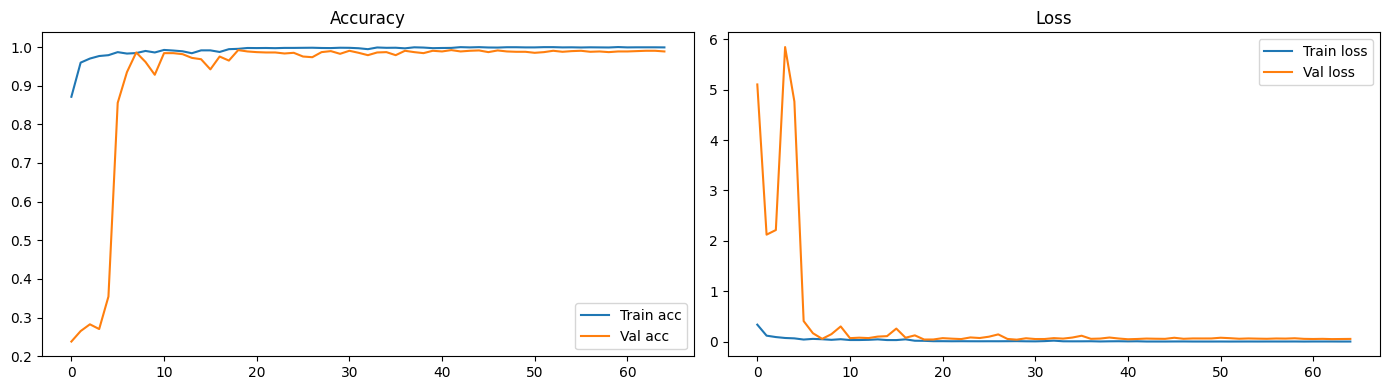

In [62]:
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

if acc and val_acc and loss and val_loss:
    print(f"Final Train Accuracy : {acc[-1]:.4f}")
    print(f"Final Val Accuracy   : {val_acc[-1]:.4f}")
    print(f"Final Train Loss     : {loss[-1]:.4f}")
    print(f"Final Val Loss       : {val_loss[-1]:.4f}")
    print(f"Best Val Accuracy    : {max(val_acc):.4f}")
    print(f"Best Val Loss        : {min(val_loss):.4f}")

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Train acc")
plt.plot(val_acc, label="Val acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Train loss")
plt.plot(val_loss, label="Val loss")
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()

## Training Results and Learning Curve Analysis

This block summarizes the final training and validation performance and visualizes the learning dynamics of the CNN over all epochs.  
The final training accuracy reaches **99.91%**, while validation accuracy stabilizes at **98.86%**, indicating strong predictive performance with good generalization.

The corresponding loss values show a very low **training loss (0.0012)** and a higher but stable **validation loss (0.0531)**.  
This gap is expected in an augmented training setup, where the model is exposed to more challenging, distorted samples during training, while validation data remains clean and unmodified.

The learning curves illustrate that:
- Training accuracy increases steadily and saturates near convergence.
- Validation accuracy remains consistently high, with a best observed value of **99.21%**.
- Validation loss exhibits small fluctuations but reaches a minimum of **0.0381**, reflecting stable generalization rather than overfitting.

Overall, the curves indicate that the model has learned robust features from the augmented data, and that regularization through augmentation, dropout, and learning-rate scheduling successfully prevents severe overfitting despite full fine-tuning of a deep CNN.

In [72]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_PATH)
print("Loaded:", MODEL_PATH)

Loaded: brain_mri_preprocessing_pipeline_aug.h5


In [63]:
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

FINAL_MODEL_PATH = "brain_mri_preprocessing_pipeline_aug.h5"
model.save(FINAL_MODEL_PATH)
print("Saved model to:", FINAL_MODEL_PATH)

Test Loss     : 0.0357
Test Accuracy : 0.9878
Saved model to: brain_mri_preprocessing_pipeline_aug.h5


## Final Evaluation on the Test Set and Model Persistence

This block evaluates the trained CNN on the **held-out test set**, which has not been used during training or validation.  
The test set provides an unbiased estimate of the model’s generalization performance on completely unseen MRI images.

The model achieves a **test accuracy of 98.78%** with a **test loss of 0.0357**, which is closely aligned with the validation performance observed during training.  
This consistency indicates that the CNN generalizes well and that no significant overfitting has occurred despite full fine-tuning of the ResNet-50 backbone.

After evaluation, the trained model is saved to disk for reuse in downstream tasks such as inference and Grad-CAM visualization.  
The model is stored in HDF5 (`.h5`) format for compatibility with existing tooling and visualization scripts.  
Although this format is considered legacy in newer Keras versions, it remains fully functional and suitable for loading pretrained models for analysis.

The saved model artifact (`brain_mri_preprocessing_pipeline_aug.h5`) represents the finalized augmentation-based pipeline and serves as the reference model for interpretability analysis.

## Detailed Evaluation: Classification Metrics, Confusion Matrix, and Qualitative Predictions

This block provides a comprehensive evaluation of the trained CNN on the held-out test set using both quantitative metrics and qualitative inspection.  
Predicted class probabilities are converted into discrete class labels and compared against ground-truth labels to assess performance beyond overall accuracy.

The classification report shows consistently high precision, recall, and F1-scores across all four classes:
- **Glioma** achieves very high precision (0.9966) with slightly lower recall (0.9800), indicating rare but conservative false negatives.
- **Meningioma** shows balanced precision and recall, reflecting stable class separation.
- **No tumor** achieves the highest overall scores, confirming strong discrimination between healthy and pathological cases.
- **Pituitary** tumors are classified with high recall, indicating effective detection of this class.

The overall test accuracy of **98.78%**, together with a macro-averaged F1-score of **0.9875**, confirms that performance is not dominated by a single class and remains robust despite moderate class imbalance.

The confusion matrix visualizes remaining misclassifications and shows that most errors occur between tumor subclasses rather than between tumor and no-tumor cases, which is expected given overlapping MRI appearance patterns.

Finally, a random grid of test images is displayed with predicted and true labels.  
Correct predictions are highlighted in green, while incorrect ones are marked in orange, enabling qualitative inspection of model behavior and failure cases.  
This step supports transparent error analysis and provides context for subsequent Grad-CAM-based interpretability.

41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step
Sklearn Accuracy: 0.9877955758962624
              precision    recall  f1-score   support

      glioma     0.9966    0.9800    0.9882       300
  meningioma     0.9773    0.9837    0.9805       306
     notumor     0.9901    0.9926    0.9914       405
   pituitary     0.9868    0.9933    0.9900       300

    accuracy                         0.9878      1311
   macro avg     0.9877    0.9874    0.9875      1311
weighted avg     0.9878    0.9878    0.9878      1311



<Figure size 700x600 with 0 Axes>

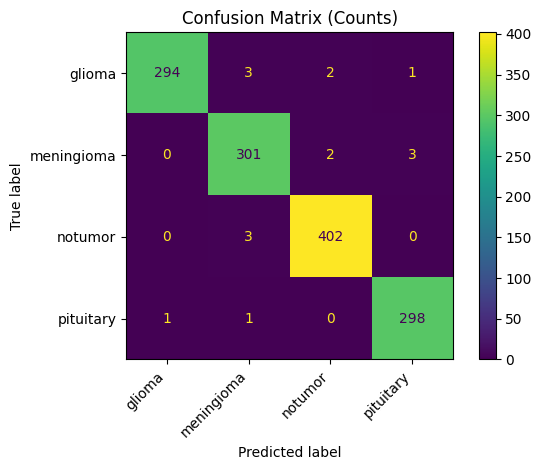

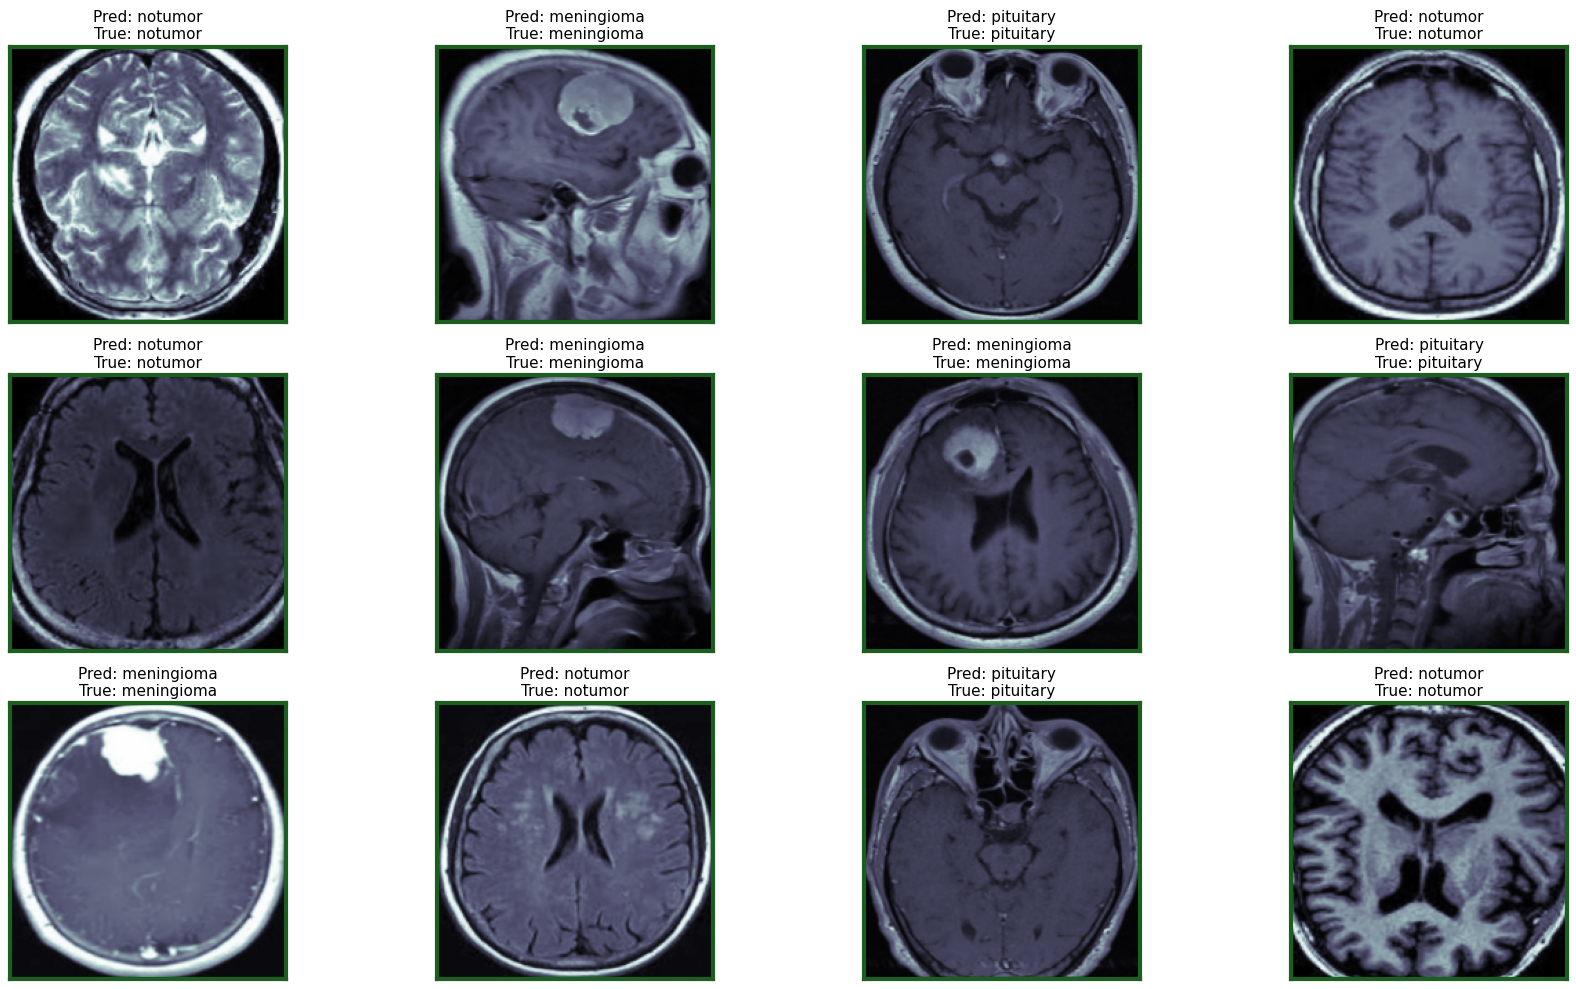

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_prob = model.predict(X_test, batch_size=32, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test_oh, axis=1)

print("Sklearn Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Counts)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Random grid with borders: correct=green, wrong=orange
def to_rgb_uint8(img01_bgr):
    img_bgr = (img01_bgr * 255).astype(np.uint8)
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

N_SHOW = 12
idxs = np.random.choice(X_test.shape[0], size=min(N_SHOW, X_test.shape[0]), replace=False)

fig = plt.figure(figsize=(18, 10))
rows = 3
cols = int(np.ceil(len(idxs) / rows))

for k, idx in enumerate(idxs):
    ax = fig.add_subplot(rows, cols, k + 1, xticks=[], yticks=[])
    ax.imshow(to_rgb_uint8(X_test[idx]))

    pred_name = CLASSES[int(y_pred[idx])]
    true_name = CLASSES[int(y_true[idx])]
    ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=11)

    border = "#1B5E20" if y_pred[idx] == y_true[idx] else "#F57C00"
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(3)
        spine.set_edgecolor(border)

plt.tight_layout()
plt.show()

In [67]:
print("Training Data length:", len(X_train))
print("Validation Data length:", len(X_val))

Training Data length: 4569
Validation Data length: 1143


## Dataset Size Verification after Train–Validation Split

This block reports the number of samples in the training and validation subsets after splitting the preprocessed dataset.  
The resulting sizes are **4,569 training images** and **1,143 validation images**, which correspond to an 80/20 split of the original training data.

Verifying dataset lengths at this stage is important in CNN training to ensure that:
- The split was applied correctly and no samples were lost or duplicated.
- The validation set is sufficiently large to provide a reliable estimate of generalization performance.
- Training batches are generated from the intended data volume.

This explicit size check acts as a final sanity verification before training begins and helps prevent subtle data handling errors from affecting model optimization and evaluation.

## Reloading the Saved Model for Evaluation and Interpretability

This optional block reloads a previously saved model from disk instead of relying on the in-memory training instance.  
Reloading the model ensures that all subsequent analyses—such as evaluation, visualization, or Grad-CAM—are performed on the **exact saved model state**, rather than on a potentially modified or recompiled version.

This step is particularly useful for:
- Verifying model persistence and reproducibility.
- Separating training from post-hoc analysis workflows.
- Ensuring that interpretability methods (e.g., Grad-CAM) operate on the **best validated model** saved during training.

By explicitly reloading the model, the workflow remains modular and robust, allowing interpretability and evaluation to be performed independently of the training session.

In [71]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_PATH)
print("Loaded:", MODEL_PATH)

Loaded: brain_mri_preprocessing_pipeline_aug.h5


In [73]:
from tensorflow.keras.preprocessing import image as kimage

PRED_LABELS = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

def predict_single(path, target_size=(200, 200)):
    img = kimage.load_img(path, target_size=target_size)
    x = kimage.img_to_array(img).astype(np.float32) / 255.0
    x = np.expand_dims(x, axis=0)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    print("\nImage:", path)
    print("Pred :", PRED_LABELS[idx])
    print("Prob :", {PRED_LABELS[i]: float(probs[i]) for i in range(len(PRED_LABELS))})

sample_paths = {
    "glioma":     "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/glioma/Te-gl_0012.jpg",
    "meningioma": "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/meningioma/Te-me_0092.jpg",
    "notumor":    "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/notumor/Te-no_0012.jpg",
    "pituitary":  "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/pituitary/Te-pi_0024.jpg",
}

for _, p in sample_paths.items():
    predict_single(p, target_size=(200, 200))


Image: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/glioma/Te-gl_0012.jpg
Pred : glioma_tumor
Prob : {'glioma_tumor': 0.9999990463256836, 'meningioma_tumor': 1.2004593941128405e-07, 'no_tumor': 5.476119895320153e-07, 'pituitary_tumor': 2.8947530950063083e-07}

Image: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/meningioma/Te-me_0092.jpg
Pred : glioma_tumor
Prob : {'glioma_tumor': 0.9997565150260925, 'meningioma_tumor': 2.859272171917837e-06, 'no_tumor': 0.0002363952371524647, 'pituitary_tumor': 4.188872935628751e-06}

Image: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/notumor/Te-no_0012.jpg
Pred : no_tumor
Prob : {'glioma_tumor': 0.0063943942077457905, 'meningioma_tumor': 0.007960131391882896, 'no_tumor': 0.9821419715881348, 'pituitary_tumor': 0.0035035181790590286}

Image: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/pituitary/Te-pi_0024.jpg
Pred : glioma_tumor
Prob : {'glioma

In [74]:
import time
import pandas as pd
from tensorflow.keras.preprocessing import image as kimage

directories = {
    "glioma":     "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/glioma",
    "meningioma": "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/meningioma",
    "notumor":    "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/notumor",
    "pituitary":  "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/pituitary",
}

def measure_prediction_time(model, directory, target_size=(200, 200)):
    times = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img = kimage.load_img(img_path, target_size=target_size)
        x = kimage.img_to_array(img).astype(np.float32) / 255.0
        x = np.expand_dims(x, axis=0)

        t0 = time.time()
        _ = model.predict(x, verbose=0)
        t1 = time.time()

        times.append(t1 - t0)
    return times

rows = []
all_times = []

for label, directory in directories.items():
    times = measure_prediction_time(model, directory)
    if len(times) == 0:
        continue
    all_times.extend(times)
    rows.append({
        "Category": label,
        "Average Time (s)": float(np.mean(times)),
        "Max Time (s)": float(np.max(times)),
        "Min Time (s)": float(np.min(times)),
        "N Images": len(times)
    })

if all_times:
    rows.append({
        "Category": "Overall",
        "Average Time (s)": float(np.mean(all_times)),
        "Max Time (s)": float(np.max(all_times)),
        "Min Time (s)": float(np.min(all_times)),
        "N Images": len(all_times)
    })

df_time = pd.DataFrame(rows)
print(df_time)

     Category  Average Time (s)  Max Time (s)  Min Time (s)  N Images
0      glioma          0.068635      0.189821      0.065405       300
1  meningioma          0.067905      0.122530      0.064514       306
2     notumor          0.068204      0.135548      0.065173       405
3   pituitary          0.069036      0.084299      0.066662       300
4     Overall          0.068424      0.189821      0.064514      1311


## Inference Time Analysis: Prediction Latency per Class

This block measures the **inference time** of the trained CNN on individual MRI images from the test dataset.  
For each class-specific test directory, images are loaded one by one, preprocessed to match the training input format, and passed through the model while recording prediction latency.

The timing is measured at the **single-image level**, reflecting realistic deployment scenarios where predictions are made sequentially rather than in large batches.  
For each class, the average, minimum, and maximum prediction times are computed, along with the total number of evaluated images.

The results show a highly consistent inference time across all classes:
- Average prediction time per image is approximately **0.068 seconds**.
- Latency variation between classes is minimal, indicating stable computational behavior independent of tumor type.
- The overall inference time across **1,311 test images** remains within a narrow range, with no outliers indicating abnormal slowdowns.

This analysis demonstrates that the model not only achieves high classification accuracy, but also operates with **predictable and efficient inference performance**, making it suitable for real-time or near–real-time clinical decision support scenarios.